# 6. Feature Importance Analysis

## Snippet 6.1 Generating a Set of Informed, Redundant and Noisy Explanatory Variables.

In [11]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=.0):
    #generate random dataset
    from sklearn.datasets import make_classification
    np.random.seed(random_state)
    X,y = make_classification(n_samples=n_samples, n_features=n_features-n_redundant,
                             n_informative=n_informative, n_redundant=0, shuffle=False, random_state=random_state)
    cols = ['I_'+str(i) for i in range(n_informative)]
    cols += ['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]
    X,y = pd.DataFrame(X,columns=cols),pd.Series(y)
    i = np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)] = X['I_'+str(j)]+np.random.normal(size=X.shape[0])*sigmaStd
    return X,y

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.discrete.discrete_model as sm
X,y = getTestData(40,5,30,10000,sigmaStd=.1)
ols = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


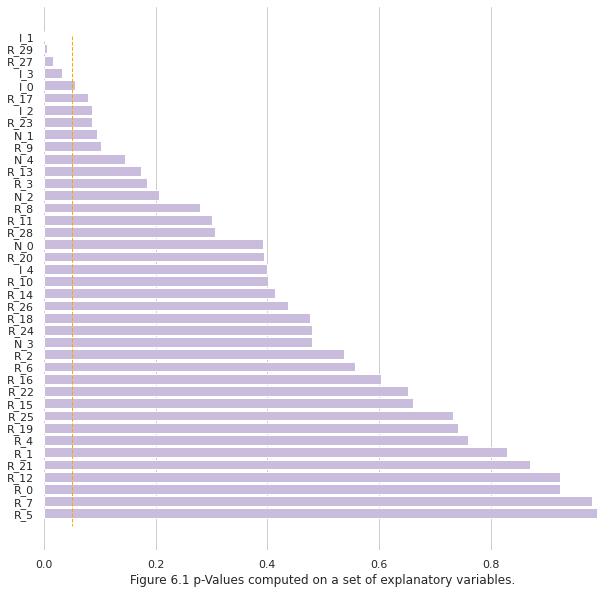

In [77]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Load the example car crash dataset
pval = pd.DataFrame(ols.pvalues.sort_values(ascending=True), columns=["p-value"])

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="p-value", y=pval.index, data=pval, color="#c8b7e1")
plt.vlines(x = 0.05, ymin = 0, ymax = len(pval), color = 'orange', linewidth=1, linestyles='--')
ax.set(xlim=(0, .999), ylabel="",
       xlabel="Figure 6.1 p-Values computed on a set of explanatory variables.")
# ax.grid(False)
sns.despine(left=True, bottom=True)

## Snippet 6.2 Implementation of an Ensemble MDI Method

In [101]:
def featImpMDI(fit, featNames):
    #feature importance based on IS mean impurity redution
    df0 = {i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0,orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)
    imp = pd.concat({'mean':df0.mean(), 'std':df0.std()*df0.shape[0]**-.5}, axis=1) #CLT
    imp /= imp['mean'].sum()
    return imp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X,y = getTestData(40,5,30,10000,sigmaStd=.1)
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features = 1., max_samples=1., oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI(fit, featNames=X.columns)

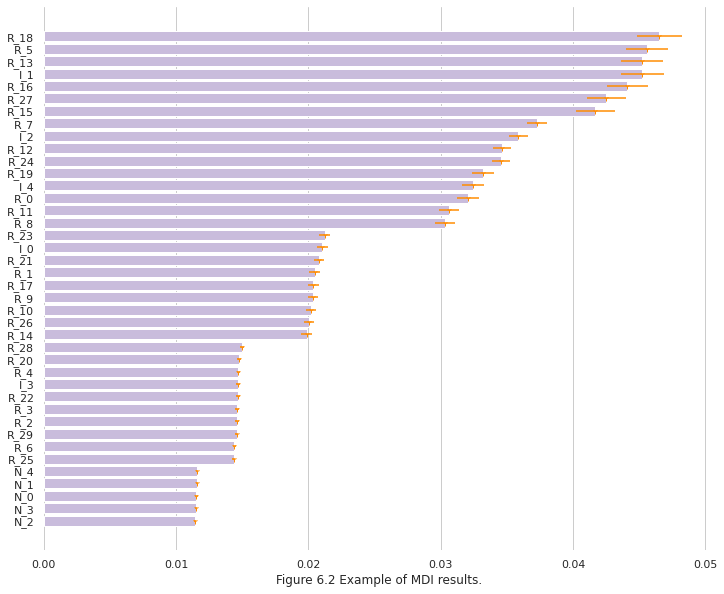

In [147]:
imp.sort_values(by='mean', ascending=False, inplace=True)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
sns.barplot(x="mean", y=imp.index, data=imp, color="#c8b7e1")
ax.errorbar(x=imp['mean'], y=[i for i in range(len(imp))], xerr=imp['std'], fmt='1', color='darkorange')
ax.set(ylabel="", xlabel="Figure 6.2 Example of MDI results.")
sns.despine(left=True, bottom=True)

In [113]:
imp

,mean,std
R_18,0.046496,0.001697
R_5,0.045597,0.001585
R_13,0.045237,0.001585
I_1,0.045226,0.001614
R_16,0.044099,0.001536
R_27,0.042509,0.001475
R_15,0.041688,0.001469
R_7,0.037260,0.000749
I_2,0.035871,0.000694
R_12,0.034615,0.000679
